In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, recall_score
import optuna
import myfunctions
import importlib
import warnings
warnings.filterwarnings('ignore')

# Load and transform data

In [501]:
churn_train_model_fe = pd.read_pickle('churn_train_model_fe.pcl')
churn_train_model_fe

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id
0,0,0.0,13.843750,1.480469,0.000000,5.324219,0,19.046875,1.657227,0.000000,...,0.0,1.480469,NaN,0.0,NaN,13.007812,NaN,0.000000,0.0,1545052.0
1,0,0.0,11.359375,1.000000,1.000000,5.324219,0,0.000000,1.000977,15.015625,...,0.0,1.480469,NaN,0.0,NaN,18.171875,NaN,0.000000,0.0,1545235.0
2,0,0.0,10.265625,0.000000,0.000000,5.324219,0,0.000000,1.015625,11.617188,...,0.0,1.480469,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,1549358.0
3,0,0.0,9.976562,1.033203,1.000000,5.324219,0,0.000000,1.002930,11.617188,...,0.0,1.480469,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,1549591.0
4,0,0.0,6.750000,1.000977,1.000977,5.324219,0,28.859375,1.047852,0.000000,...,0.0,NaN,1.0,0.0,NaN,13.007812,NaN,NaN,0.0,1558772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.0,8.335938,1.009766,1.001953,5.324219,0,0.000000,1.334961,14.328125,...,0.0,2.207031,NaN,0.0,NaN,NaN,NaN,20.140625,0.0,130753784.0
149996,0,0.0,14.039062,1.005859,1.066406,5.324219,0,0.000000,1.208008,12.789062,...,0.0,1.480469,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,130753816.0
149997,0,0.0,13.226562,1.000977,1.000977,5.324219,0,0.000000,1.037109,2.207031,...,0.0,1.480469,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,130754336.0
149998,0,0.0,19.531250,1.000977,0.000000,5.324219,0,15.460938,1.276367,9.109375,...,0.0,1.480469,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,130754632.0


In [502]:
df_train = churn_train_model_fe.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 817 entries, Ama_rchrgmnt_sum_max_mnt1 to abon_id
dtypes: float16(773), float32(1), float64(11), int8(32)
memory usage: 238.9 MB


In [503]:
df_train = myfunctions.reduce_mem_usage(df_train, verbose=True)

Mem. usage decreased to 238.90 Mb (0.0% reduction)


In [504]:
# target values
df_train['target'].value_counts()

target
0.0    140414
1.0      9586
Name: count, dtype: int64

In [505]:
w = round(140414 / 9586, 2)
w

14.65

<Axes: xlabel='target', ylabel='count'>

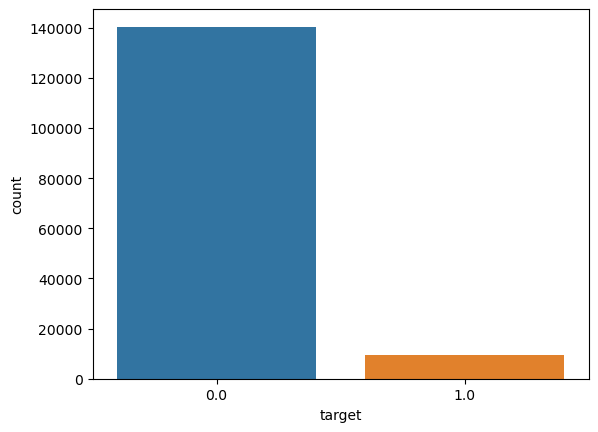

In [506]:
df_train = df_train.astype('float32')
sns.countplot(x='target', data=df_train)

## Imbalanced dataset
So we deal with high imbalanced dataset, where target value is minority class

# EDA technicks 

- computing custom function preproccess data
- removed unnecessary columns as abon_id column
- fill missed data '-1'
- transform data using StandardScaler
- removed high correlated featres (corr ratio > 0.98), to evoid multicolianarity

In [509]:
scaler = StandardScaler()
df_train_pp = myfunctions.preproccess_data(df_train, scaler)

# LightGBM is a popular gradient boosting library

that can be effective for classification.
It usually shows high performance and is flexible in terms of hyperparameter tuning.

## model 1: LightGBM base model

In [512]:
y = churn_train_model_fe['target']
X = df_train_pp

In [513]:
fea1 = df_train_pp.columns.to_list()

In [514]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y, shuffle=True)

In [515]:
# Initialize the LGBMClassifier
model_1 = LGBMClassifier(random_state=42)

# Train the model
model_1.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)], 
            callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=0)])

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063908 -> initscore=-2.684264
[LightGBM] [Info] Start training from score -2.684264


LGBMClassifier(random_state=42)

### Evaluate first model

In [596]:
result_df = pd.DataFrame(columns=['Model', 'AUC score', 'F1 score', 'Recall', 'TP', 'FN', 'FP'])

In [598]:
# Make predictions
y_pred = model_1.predict(X_test)
y_pred_proba = model_1.predict_proba(X_test)[:, 1] 
# eval metrics
model_1_results, result_df = myfunctions.eval_model('model_1', y_test, y_pred, y_pred_proba, result_df)
result_df

Confusion Matrix:
 [[27880   203]
 [ 1197   720]]


,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.95063,0.507042,0.375587,720,1197,203


In [519]:
importlib.reload(myfunctions)

<module 'myfunctions' from '/Users/nataliamarko/Downloads/myfunctions.py'>

[LightGBM] [Info] Number of positive: 1534, number of negative: 22466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84527
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 570
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063917 -> initscore=-2.684124
[LightGBM] [Info] Start training from score -2.684124


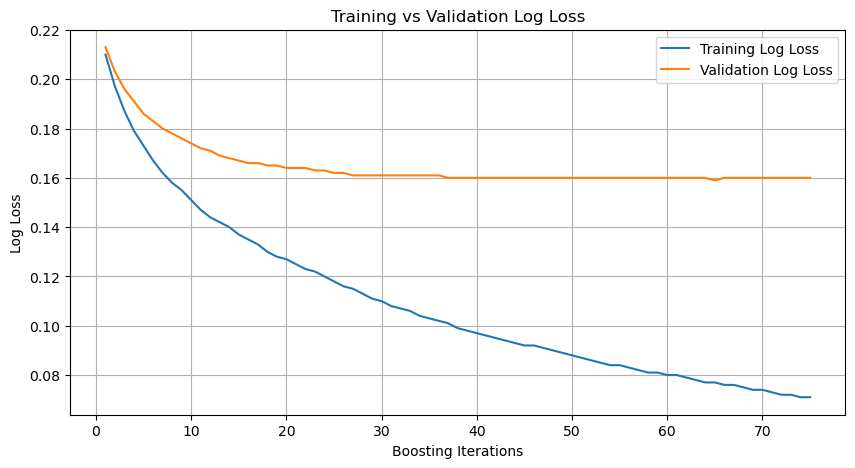

In [520]:
myfunctions.train_plot_eval(model_1, X_test, y_test, st=10)

## model 2: class weight adjustment

In [522]:
class_ratio = {0: 1, 1: w}  # w calc before w=14.68

In [523]:
model_weight = LGBMClassifier(class_weight=class_ratio, random_state=42)

myfunctions.train_and_eval(model_weight, X_train, y_train, X_test, y_test, st=10)

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500044 -> initscore=0.000177
[LightGBM] [Info] Start training from score 0.000177
AUC Score: 0.9022904958810245
F1 Score: 0.4172581767571329
Recall Score: 0.7819509650495566
Confusion Matrix:
 [[24314  3769]
 [  418  1499]]


(array([0.01143736, 0.17178676, 0.02440997, ..., 0.05702522, 0.18320157,
        0.55572112]),
 array([0., 0., 0., ..., 0., 0., 1.], dtype=float16))

In [600]:
# Make predictions
y_pred = model_weight.predict(X_test)
y_pred_proba = model_weight.predict_proba(X_test)[:, 1] 
# eval metrics
model_2_results, result_df = myfunctions.eval_model('model_weight', y_test, y_pred, y_pred_proba, result_df)
result_df

Confusion Matrix:
 [[24238  3845]
 [  230  1687]]


,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.950630,0.507042,0.375587,720,1197,203
1,model_weight,0.946277,0.452947,0.880021,1687,230,3845


[LightGBM] [Info] Number of positive: 1534, number of negative: 22466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84527
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 570
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500079 -> initscore=0.000316
[LightGBM] [Info] Start training from score 0.000316


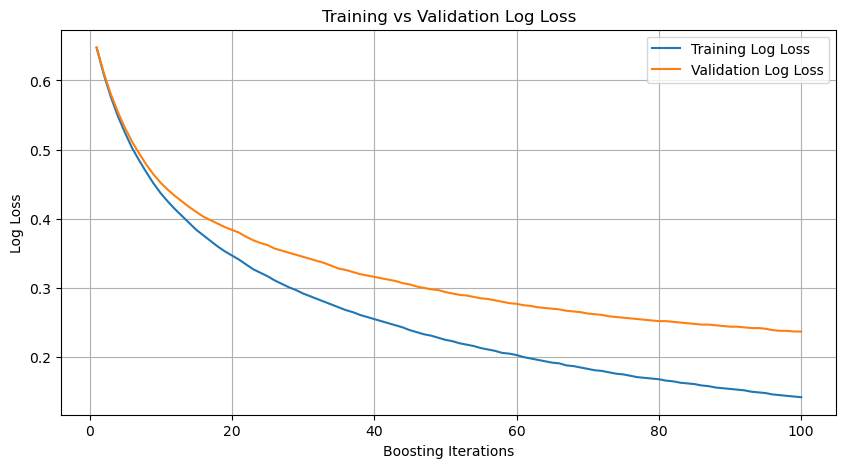

In [525]:
myfunctions.train_plot_eval(model_2, X_test, y_test, st=10)

In [526]:
# Test a range of class weights
for w in [11, 13, 15, 17, 19, 20]:
    class_weight = {0: 1, 1: w}
    model = LGBMClassifier(class_weight=class_weight, force_col_wise=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Weight for class 1: {w}")
    print(f1_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428893 -> initscore=-0.286368
[LightGBM] [Info] Start training from score -0.286368
Weight for class 1: 11
0.44655065257924176
[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470207 -> initscore=-0.119314
[LightGBM] [Info] Start training from score -0.119314
Weight for class 1: 13
0.4291367433680199
[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: p

### Optimal Weight Finding: 

The class weight of 11 gives the best performance according to upper results.

It might be useful to explore slightly above and below this weight to fine-tune the performance.

Will use a narrower range around this weight to see if there's an even better setting.

In [528]:
# Test a range of class weights
for w in np.arange(3, 5, 0.1):
    class_weight = {0: 1, 1: w}
    model = LGBMClassifier(class_weight=class_weight, force_col_wise=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Weight for class 1: {w}")
    print(f1_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169997 -> initscore=-1.585651
[LightGBM] [Info] Start training from score -1.585651
Weight for class 1: 3.0
0.5170101812763844
[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174673 -> initscore=-1.552862
[LightGBM] [Info] Start training from score -1.552862
Weight for class 1: 3.1
0.5214814814814814
[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: 

In [529]:
best_weight = 4.1
class_ratio = {0: 1, 1: best_weight}

## model 3: model_best_weight

In [531]:
model_best_weight = LGBMClassifier(class_weight=class_ratio, force_col_wise=True, random_state=42)

myfunctions.train_and_eval(model_best_weight, X_train, y_train, X_test, y_test, st=10)

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Total Bins 94085
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218697 -> initscore=-1.273277
[LightGBM] [Info] Start training from score -1.273277
AUC Score: 0.9036489959127232
F1 Score: 0.5192264947766171
Recall Score: 0.6092853416797078
Confusion Matrix:
 [[26669  1414]
 [  749  1168]]


(array([0.00938701, 0.03568706, 0.01132623, ..., 0.01340525, 0.04029197,
        0.2480293 ]),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float16))

In [602]:
# Make predictions
y_pred = model_best_weight.predict(X_test)
y_pred_proba = model_best_weight.predict_proba(X_test)[:, 1] 
# eval metrics
model_2_results, result_df = myfunctions.eval_model('model_best_weight', y_test, y_pred, y_pred_proba, result_df)
result_df

Confusion Matrix:
 [[26757  1326]
 [  649  1268]]


,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.950630,0.507042,0.375587,720,1197,203
1,model_weight,0.946277,0.452947,0.880021,1687,230,3845
2,model_best_weight,0.948920,0.562181,0.661450,1268,649,1326


## model 4: Recursive Feature Elimination (RFE)
RFE is a powerful method that recursively removes the least important features (based on model weights or feature importances) and builds a model on the remaining features to identify the best performing feature subset.

In [534]:
from sklearn.feature_selection import RFE

# Initialize the model with reduced verbosity
model_best_weight_rfe = LGBMClassifier(
    class_weight=class_ratio, 
    force_col_wise=True, 
    random_state=42, 
    verbose=-1
)

# Configure RFE with the silent model
rfe = RFE(
    estimator=model_best_weight_rfe, 
    n_features_to_select=100, 
    step=10, 
    verbose=0 
)

# Fit RFE - This should be silent now
rfe.fit(X_train, y_train)

# Transform training data using RFE
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Retrain the model on reduced features with silenced output
model_best_weight_rfe.fit(X_train_rfe, y_train)

LGBMClassifier(class_weight={0: 1, 1: 4.1}, force_col_wise=True,
               random_state=42, verbose=-1)

In [604]:
y_pred = model_best_weight_rfe.predict(X_test_rfe)
y_pred_proba = model_best_weight_rfe.predict_proba(X_test_rfe)[:, 1] 
# eval metrics
model_3_results, result_df = myfunctions.eval_model('model_best_weight_rfe', y_test, y_pred, y_pred_proba, result_df)
result_df

Confusion Matrix:
 [[26648  1435]
 [  765  1152]]


,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.950630,0.507042,0.375587,720,1197,203
1,model_weight,0.946277,0.452947,0.880021,1687,230,3845
2,model_best_weight,0.948920,0.562181,0.661450,1268,649,1326
3,model_best_weight_rfe,0.901311,0.511545,0.600939,1152,765,1435


In [536]:
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))

# Get the support and ranking of the features
# print("Features ranked (1 being selected):", rfe.ranking_)
# print("Feature support mask:", rfe.support_)

AUC: 0.9032966050724778
F1 Score: 0.5168589174800354


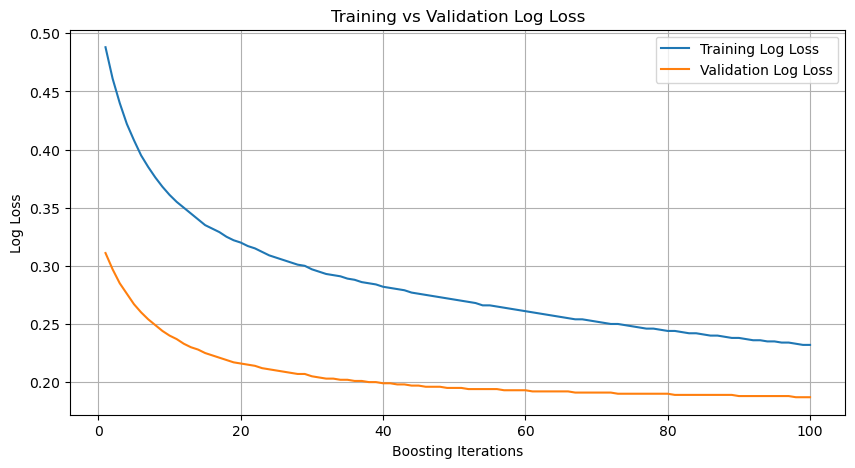

In [537]:
myfunctions.train_plot_eval(model_best_weight_rfe, X_train_rfe, y_train, st=100)

In [578]:
# Get the mask of selected features
selected_features_mask = rfe.support_

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_features_mask]
fea_100 = selected_feature_names.to_list()
print("Selected features:", selected_feature_names)

Selected features: Index(['voice_out_tar_dur_std_mnt1', 'voice_in_fix_tar_dur_mea_mnt3',
       'voice_in_cmpttrs_avg_durmax_mnt3', 'voice_in_tar_dur_td_mnt3',
       'conn_in_uniq_cnt_td_mnt3', 'voice_in_tar_dur_std_mnt1',
       'content_cnt_mea_mnt1', 'all_home_clc_td_mnt3', 'pay_sum_td_mnt3',
       'sms_in_cnt_td_mnt3', 'content_cnt_mea_wk1', 'all_cnt_std_mnt1',
       'sms_in_cnt_mea_mnt1', 'voice_mts_in_dwork_part_min_mnt1',
       'voice_in_td_cnt_mea_mnt1', 'non_accum_internet_vol_mea_wk1',
       'voice_mts_out_nwork_partmea_mnt1', 'data_3g_dou_td_mnt3',
       'sms_in_cnt_mea_mnt3', 'content_cnt_td_mnt3', 'content_cnt_std_mnt1',
       'data_3g_tv_cnt_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3',
       'voice_in_cmpttrs_avg_durmea_wk1', 'gprs_tar_vol_min_mnt1',
       'data_3g_tv_cnt_std_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1',
       'voice_mts_out_dwork_partmin_mnt1', 'voice_in_fix_tar_dur_td_mnt3',
       'num_act_days_std_mnt3', 'voice_out_td_cnt_mea_wk1',
       'vo

# Tuning the model

## model 5: tune params

In [ ]:
params = {
    'num_leaves': 50,           # Increased from a lower number to allow the model to learn more complex patterns
    'min_child_samples': 20,    # Reduced to allow more specific leaf decisions
    'learning_rate': 0.03,      # Reduced to improve the convergence over more epochs
    'reg_lambda': 0.5,          # Adjust regularization to combat any potential overfit
    'max_depth': -1,            # No limit on depth, higher depth allows model to learn more complex patterns
    'n_estimators': 300,       # Increase the number of trees to allow more learning capacity
    'force_col_wise': True,     # Optimization for faster training
    'verbose': -1               # Less verbose
}

model_tuned = LGBMClassifier(**params, class_weight=class_ratio, random_state=42)

myfunctions.train_plot_eval(model_tuned, X_train[fea_100], y_train, st=20)

In [606]:
y_pred = model_tuned.predict(X_test[fea_100])
y_pred_proba = model_tuned.predict_proba(X_test[fea_100])[:, 1] 
# eval metrics
model_5_results, result_df = myfunctions.eval_model('model_tuned_100_feas', y_test, y_pred, y_pred_proba, result_df)
result_df

Confusion Matrix:
 [[26754  1329]
 [  789  1128]]


,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.950630,0.507042,0.375587,720,1197,203
1,model_weight,0.946277,0.452947,0.880021,1687,230,3845
2,model_best_weight,0.948920,0.562181,0.661450,1268,649,1326
3,model_best_weight_rfe,0.901311,0.511545,0.600939,1152,765,1435
4,model_tuned_100_feas,0.902906,0.515775,0.588419,1128,789,1329


## model 6: lets loop through the learning rates and depths 

to find best params

In [584]:
from sklearn.metrics import log_loss

# Parameters to experiment with

learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2]
depths = [5, 10, 15, 20] 

results = {}
for rate in learning_rates:
    for depth in depths:
        params = {
            'learning_rate': rate,
            'max_depth': depth,
            'num_leaves': 2*depth,
            'n_estimators': 300,
            'random_state': 42,
            'metric': 'binary_logloss',
            'force_col_wise': True,
            'verbose': -1,
            'min_child_samples': 20,  # Higher value to prevent overfitting
            'min_gain_to_split': 0.01  # Adjust gain required to split
        }
        model = LGBMClassifier(**params, class_weight=class_ratio)
        model.fit(X_train[fea_100], y_train, 
                  eval_set=[(X_test[fea_100], y_test)], 
                  callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=0)])
        y_pred_proba = model.predict_proba(X_test[fea_100])[:, 1]
        loss = log_loss(y_test, y_pred_proba)
        results[(rate, depth)] = loss
        print(f"Learning rate: {rate}, Depth: {depth}, Log Loss: {loss:.5f}")

Learning rate: 0.01, Depth: 5, Log Loss: 0.21744
Learning rate: 0.01, Depth: 10, Log Loss: 0.21084
Learning rate: 0.01, Depth: 15, Log Loss: 0.20824
Learning rate: 0.01, Depth: 20, Log Loss: 0.20617
Learning rate: 0.05, Depth: 5, Log Loss: 0.19993
Learning rate: 0.05, Depth: 10, Log Loss: 0.19443
Learning rate: 0.05, Depth: 15, Log Loss: 0.18947
Learning rate: 0.05, Depth: 20, Log Loss: 0.18514
Learning rate: 0.1, Depth: 5, Log Loss: 0.19573
Learning rate: 0.1, Depth: 10, Log Loss: 0.18749
Learning rate: 0.1, Depth: 15, Log Loss: 0.17920
Learning rate: 0.1, Depth: 20, Log Loss: 0.17442
Learning rate: 0.15, Depth: 5, Log Loss: 0.19354
Learning rate: 0.15, Depth: 10, Log Loss: 0.18275
Learning rate: 0.15, Depth: 15, Log Loss: 0.17512
Learning rate: 0.15, Depth: 20, Log Loss: 0.16878
Learning rate: 0.2, Depth: 5, Log Loss: 0.19224
Learning rate: 0.2, Depth: 10, Log Loss: 0.18033
Learning rate: 0.2, Depth: 15, Log Loss: 0.17418
Learning rate: 0.2, Depth: 20, Log Loss: 0.16811


In [585]:
from sklearn.metrics import log_loss

# Parameters to experiment with

learning_rates = [0.05, 0.1, 0.15, 0.2]
depths = [20, 25, 30] 

results = {}
for rate in learning_rates:
    for depth in depths:
        params = {
            'learning_rate': rate,
            'max_depth': depth,
            'num_leaves': 2*depth,
            'n_estimators': 300,
            'random_state': 42,
            'metric': 'binary_logloss',
            'force_col_wise': True,
            'verbose': -1,
            'min_child_samples': 20,  # Higher value to prevent overfitting
            'min_gain_to_split': 0.01  # Adjust gain required to split
        }
        model = LGBMClassifier(**params, class_weight=class_ratio)
        model.fit(X_train[fea_100], y_train, 
                  eval_set=[(X_test[fea_100], y_test)], 
                  callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=0)])
        y_pred_proba = model.predict_proba(X_test[fea_100])[:, 1]
        loss = log_loss(y_test, y_pred_proba)
        results[(rate, depth)] = loss
        print(f"Learning rate: {rate}, Depth: {depth}, Log Loss: {loss:.5f}")

Learning rate: 0.05, Depth: 20, Log Loss: 0.18514
Learning rate: 0.05, Depth: 25, Log Loss: 0.18145
Learning rate: 0.05, Depth: 30, Log Loss: 0.17788
Learning rate: 0.1, Depth: 20, Log Loss: 0.17442
Learning rate: 0.1, Depth: 25, Log Loss: 0.17021
Learning rate: 0.1, Depth: 30, Log Loss: 0.16782
Learning rate: 0.15, Depth: 20, Log Loss: 0.16878
Learning rate: 0.15, Depth: 25, Log Loss: 0.16697
Learning rate: 0.15, Depth: 30, Log Loss: 0.16372
Learning rate: 0.2, Depth: 20, Log Loss: 0.16811
Learning rate: 0.2, Depth: 25, Log Loss: 0.16840
Learning rate: 0.2, Depth: 30, Log Loss: 0.16761


In [545]:
def learning_rate_decay(boosting_round, num_rounds, initial_lr=0.1, decay_rate=0.99):
    """ Returns a learning rate that decays exponentially. """
    return initial_lr * (decay_rate ** boosting_round)

In [586]:
from lightgbm import LGBMClassifier, early_stopping, callback
import lightgbm as lgb

results = {}
initial_lr = 0.3  # Start with a default learning rate
decay_rate = 0.99  # Define how fast the learning rate decays
num_rounds = 300  # Total number of boosting rounds

params = {
    'max_depth': 40,
    'num_leaves': 50,
    'n_estimators': num_rounds,
    'random_state': 42,
    'metric': 'binary_logloss',
    'force_col_wise': True,
    'verbose': -1,
    'min_child_samples': 20,
    'min_gain_to_split': 0.01
}

for depth in [30, 40, 50]:
    params.update({'max_depth': depth, 'num_leaves': 2*depth})
    model = LGBMClassifier(**params, class_weight=class_ratio)
    
    # Setting up the learning rate decay callback
    lr_scheduler = callback.reset_parameter(learning_rate=lambda iter: learning_rate_decay(iter, num_rounds, initial_lr, decay_rate))
    
    model.fit(X_train[fea_100], y_train, 
              eval_set=[(X_test[fea_100], y_test)], 
              callbacks=[lr_scheduler, lgb.early_stopping(stopping_rounds=10, verbose=0)])
    
    y_pred_proba = model.predict_proba(X_test[fea_100])[:, 1]
    loss = log_loss(y_test, y_pred_proba)
    results[(initial_lr, decay_rate, depth)] = loss
    print(f"Initial LR: {initial_lr}, Decay: {decay_rate}, Depth: {depth}, Log Loss: {loss:.5f}")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218697 -> initscore=-1.273277
[LightGBM] [Info] Start training from score -1.273277
Initial LR: 0.3, Decay: 0.99, Depth: 30, Log Loss: 0.17283
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218697 -> initscore=-1.273277
[LightGBM] [Info] Start training from score -1.273277
Initial LR: 0.3, Decay: 0.99, Depth: 40, Log Loss: 0.16952
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218697 -> initscore=-1.273277
[LightGBM] [Info] Start training from score -1.273277
Initial LR: 0.3, Decay: 0.99, Depth: 50, Log Loss: 0.16702


[LightGBM] [Info] Start training from score 0.063908


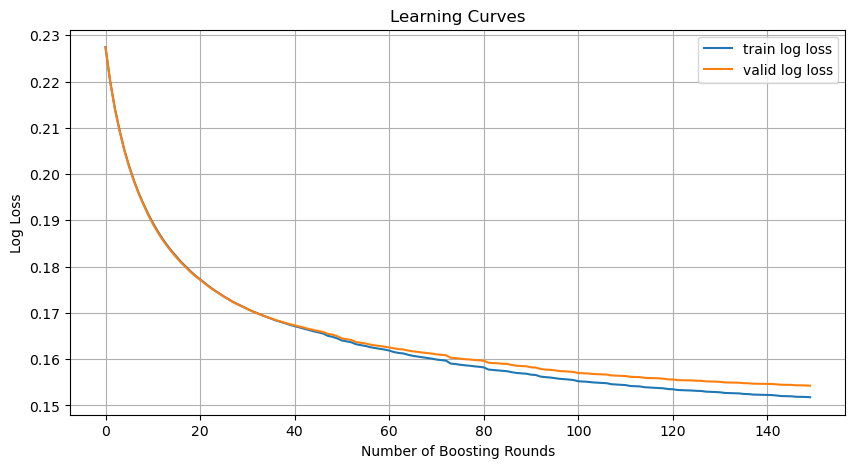

In [587]:

# Set up parameters for LightGBM
params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'num_leaves': 14,
    'n_estimators': 150,
    'random_state': 42,
    'metric': 'binary_logloss',
    'force_col_wise': True,
    'verbose': -1,
    'min_child_samples': 20,
    'min_gain_to_split': 0.01
}

# Set up dataset for LightGBM
train_data = lgb.Dataset(X_train[fea_100], label=y_train)
valid_data = lgb.Dataset(X_test[fea_100], label=y_test, reference=train_data)

# Define a learning rate decay function
def learning_rate_decay(boosting_round, num_rounds, initial_lr=0.05, decay_rate=0.99):
    return initial_lr * (decay_rate ** boosting_round)

# Train with callback for learning rate scheduling
evals_result = {}
model_6 = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=200,
    callbacks=[
        lgb.reset_parameter(learning_rate=lambda iter: learning_rate_decay(iter, num_rounds=200)),
        lgb.record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=10, verbose=0)
    ]
)
def plot_learning_curves(evals_result):
    plt.figure(figsize=(10, 5))
    for key in evals_result:
        plt.plot(evals_result[key]['binary_logloss'], label=f'{key} log loss')
    plt.title('Learning Curves')
    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(evals_result)

In [689]:
y_pred_proba = model_6.predict(X_test[fea_100])

y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluating the model
model_6_results, result_df = myfunctions.eval_model('model_6_100_feas', y_test, y_pred, y_pred_proba, result_df)
print(result_df)

Confusion Matrix:
 [[27909   174]
 [ 1426   491]]
              Model  AUC score  F1 score    Recall   TP    FN   FP
0  model_6_100_feas   0.894599  0.380325  0.256129  491  1426  174


# Final training

In [703]:
y = churn_train_model_fe['target']
X = df_train_pp

In [705]:
model_1.fit(X[fea1], y)

[LightGBM] [Info] Number of positive: 9586, number of negative: 140414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95358
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 583
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063907 -> initscore=-2.684292
[LightGBM] [Info] Start training from score -2.684292


LGBMClassifier(random_state=42)

In [706]:
model_weight.fit(X[fea1], y)

[LightGBM] [Info] Number of positive: 9586, number of negative: 140414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95358
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 583
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500037 -> initscore=0.000149
[LightGBM] [Info] Start training from score 0.000149


LGBMClassifier(class_weight={0: 1, 1: 14.65}, random_state=42)

In [707]:
model_best_weight.fit(X[fea1], y)

[LightGBM] [Info] Number of positive: 9586, number of negative: 140414
[LightGBM] [Info] Total Bins 95358
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 583
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218692 -> initscore=-1.273305
[LightGBM] [Info] Start training from score -1.273305


LGBMClassifier(class_weight={0: 1, 1: 4.1}, force_col_wise=True,
               random_state=42)

In [708]:
model_best_weight_rfe.fit(X[fea_100],y)

LGBMClassifier(class_weight={0: 1, 1: 4.1}, force_col_wise=True,
               random_state=42, verbose=-1)

In [709]:
model_tuned.fit(X[fea_100],y)

LGBMClassifier(class_weight={0: 1, 1: 4.1}, force_col_wise=True,
               learning_rate=0.03, n_estimators=300, num_leaves=50,
               random_state=42, reg_lambda=0.5, verbose=-1)

In [710]:
del result_df

In [711]:
result_df = pd.DataFrame(columns=['Model', 'AUC score', 'F1 score', 'Recall', 'TP', 'FN', 'FP'])

In [712]:
models_fea1 = [model_1, model_weight, model_best_weight]
i = 1
for m in models_fea1:
    y_pred = m.predict(X)
    y_pred_proba = m.predict_proba(X)[:, 1]
    new_row, updated_result_df = myfunctions.eval_model(i, y, y_pred, y_pred_proba, result_df)
    i += 1
    print(updated_result_df)

Confusion Matrix:
 [[139446    968]
 [  5989   3597]]
  Model  AUC score  F1 score    Recall    TP    FN   FP
0     1   0.952391  0.508374  0.375235  3597  5989  968
Confusion Matrix:
 [[121402  19012]
 [  1201   8385]]
  Model  AUC score  F1 score    Recall    TP    FN     FP
0     2   0.946239  0.453452  0.874713  8385  1201  19012
Confusion Matrix:
 [[133883   6531]
 [  3260   6326]]
  Model  AUC score  F1 score    Recall    TP    FN    FP
0     3   0.949727  0.563739  0.659921  6326  3260  6531


In [722]:
models_fea100 = [model_best_weight_rfe, model_tuned]
i = 1
for m in models_fea100:
    y_pred = m.predict(X[fea_100])
    y_pred_proba = m.predict_proba(X[fea_100])[:, 1]
    new_row, updated_result_df = myfunctions.eval_model(i, y, y_pred, y_pred_proba, result_df)
    i += 1
    print(updated_result_df)

Confusion Matrix:
 [[133721   6693]
 [  3276   6310]]
  Model  AUC score  F1 score    Recall    TP    FN    FP
0     1   0.945883  0.558679  0.658252  6310  3276  6693
Confusion Matrix:
 [[134210   6204]
 [  3059   6527]]
  Model  AUC score  F1 score    Recall    TP    FN    FP
0     2   0.957524  0.584935  0.680889  6527  3059  6204


# Testing on unseen data

In [879]:
churn_test_model_fe = pd.read_pickle('churn_test_model_fe.pcl')

y = churn_test_model_fe['target']

df_test_pp = myfunctions.preproccess_test_data(churn_test_model_fe, scaler)

In [880]:
result_df = pd.DataFrame(columns=['Model', 'AUC score', 'F1 score', 'Recall', 'TP', 'FN', 'FP'])

In [881]:
importlib.reload(myfunctions)

<module 'myfunctions' from '/Users/nataliamarko/Downloads/myfunctions.py'>

In [882]:
X = df_test_pp[fea1]

In [887]:
y_pred = model_1.predict(X)
y_pred_proba = model_1.predict_proba(X)[:, 1]
new_row, result_df = myfunctions.eval_model('model_1', y, y_pred, y_pred_proba, result_df)
result_df

,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.897354,0.448398,0.329682,3100,6303,1324


In [889]:
y_pred = model_weight.predict(X)
y_pred_proba = model_weight.predict_proba(X)[:, 1]
new_row, result_df = myfunctions.eval_model('model_weght', y, y_pred, y_pred_proba, result_df)
result_df

,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.897354,0.448398,0.329682,3100,6303,1324
1,model_weght,0.899272,0.405051,0.781240,7346,2057,19523


In [891]:
y_pred = model_best_weight.predict(X)
y_pred_proba = model_best_weight.predict_proba(X)[:, 1]
new_row, result_df = myfunctions.eval_model('model_best_weight', y, y_pred, y_pred_proba, result_df)
result_df

,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.897354,0.448398,0.329682,3100,6303,1324
1,model_weght,0.899272,0.405051,0.781240,7346,2057,19523
2,model_best_weight,0.898953,0.514886,0.605126,5690,3713,7009


In [893]:
X = df_test_pp[fea_100]

In [895]:
models_fea100 = [model_best_weight_rfe, model_tuned]

In [897]:
y_pred = model_best_weight_rfe.predict(X)
y_pred_proba = model_best_weight_rfe.predict_proba(X)[:, 1]
new_row, result_df = myfunctions.eval_model('model_best_weight_rfe', y, y_pred, y_pred_proba, result_df)
result_df

,Model,AUC score,F1 score,Recall,TP,FN,FP
0,model_1,0.897354,0.448398,0.329682,3100,6303,1324
1,model_weght,0.899272,0.405051,0.781240,7346,2057,19523
2,model_best_weight,0.898953,0.514886,0.605126,5690,3713,7009
3,model_best_weight_rfe,0.898488,0.512254,0.604594,5685,3718,7108


In [899]:
y_pred = model_tuned.predict(X)
y_pred_proba = model_tuned.predict_proba(X)[:, 1]
new_row, result_df = myfunctions.eval_model('model_tuned', y, y_pred, y_pred_proba, result_df)


In [901]:
sorted_df = result_df.sort_values(by=['F1 score', 'AUC score'], ascending=[False, False])
sorted_df

,Model,AUC score,F1 score,Recall,TP,FN,FP
4,model_tuned,0.899979,0.520768,0.602680,5667,3736,6694
2,model_best_weight,0.898953,0.514886,0.605126,5690,3713,7009
3,model_best_weight_rfe,0.898488,0.512254,0.604594,5685,3718,7108
0,model_1,0.897354,0.448398,0.329682,3100,6303,1324
1,model_weght,0.899272,0.405051,0.781240,7346,2057,19523


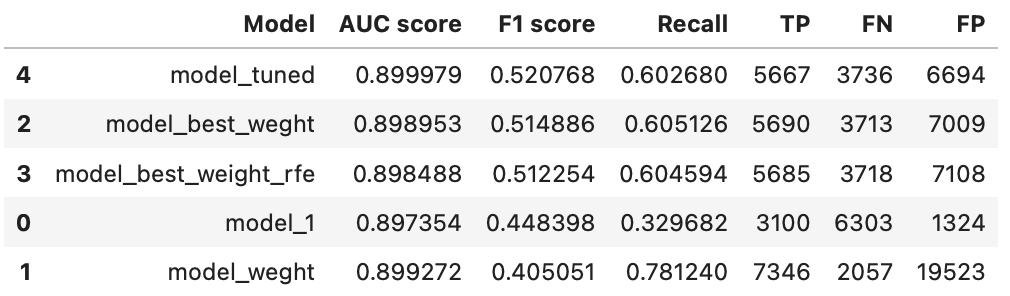

Optimal Threshold: 0.5702562159500268
Maximum F1 Score: 0.5279607783055003


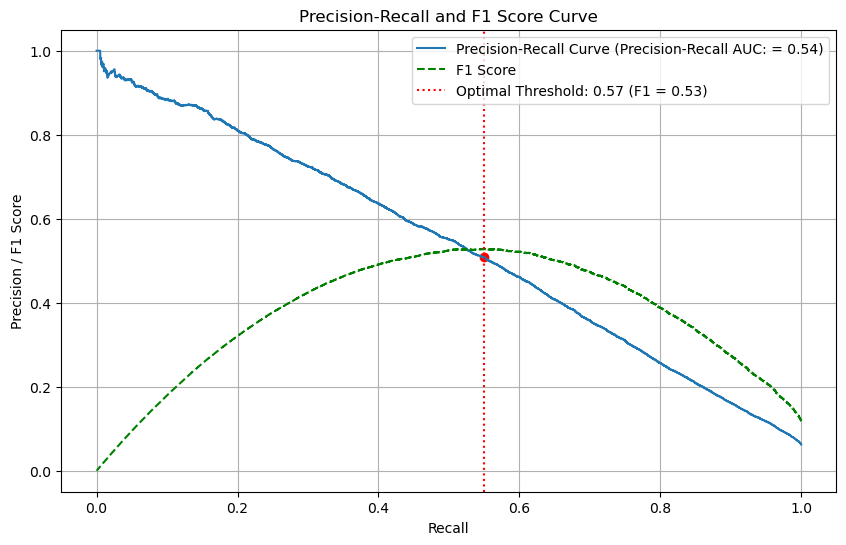

Optimal Threshold: 0.6030354316862728
Maximum F1 Score: 0.5268868172960447


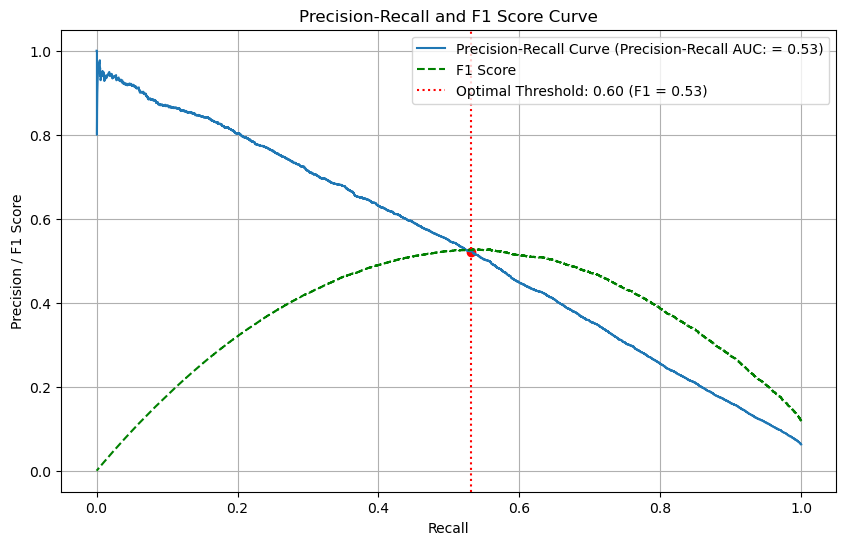

In [905]:
# get predictions for first model - 'model_tuned'
y_pred_1 = model_tuned.predict(X)
y_pred_proba_1 = model_tuned.predict_proba(X)[:, 1]
thr1 = myfunctions.get_optimal_threshold(y, y_pred_proba_1)

# get predictions for second model - 'model_best_weght'
y_pred_2 = model_best_weight_rfe.predict(X)
y_pred_proba_2 = model_best_weight_rfe.predict_proba(X)[:, 1]
thr2 = myfunctions.get_optimal_threshold(y, y_pred_proba_2)

Optimal Threshold: 0.6155034603825564
Maximum F1 Score: 0.5260722165420006


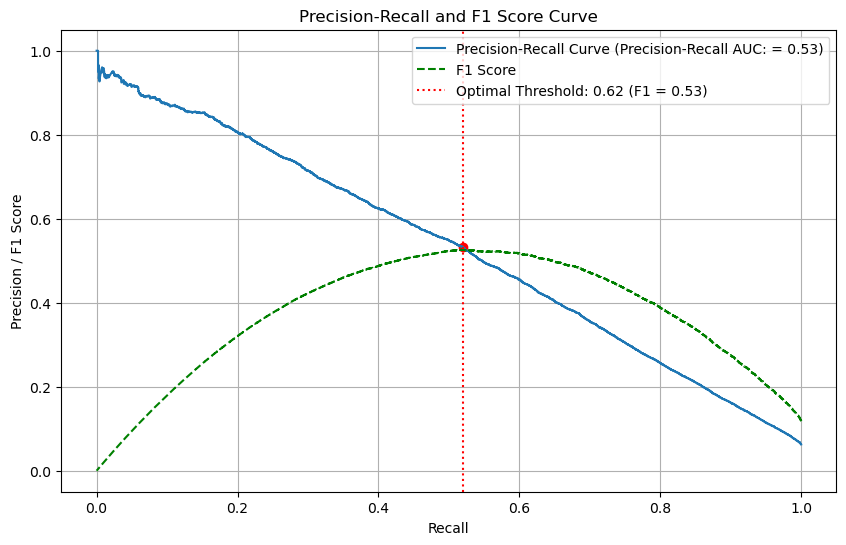

In [915]:
X_fea1 = df_test_pp[fea1]
# get predictions for third model - 'model_best_weight'
y_pred_3 = model_best_weight.predict(X_fea1)
y_pred_proba_3 = model_best_weight.predict_proba(X_fea1)[:, 1]
thr3 = myfunctions.get_optimal_threshold(y, y_pred_proba_3)

In [909]:
myfunctions.plot_confusion_matrix(y, y_pred_1, thr1)

Confusion Matrix:
 [[133903   6694]
 [  3736   5667]]


In [911]:
myfunctions.plot_confusion_matrix(y, y_pred_2, thr2)

Confusion Matrix:
 [[133489   7108]
 [  3718   5685]]


In [917]:
myfunctions.plot_confusion_matrix(y, y_pred_3, thr3)

Confusion Matrix:
 [[133588   7009]
 [  3713   5690]]


The adjustment leads to more effective identification of positive cases at the expense of a higher false positive rate, which is a worthwhile trade-off in scenarios where missing positive cases has greater consequences.

The final 3 models are quite similar on results. The fird one, on my oppinion:

- AUC 0.8989
- f1 score 0.515
- Recall score 0.605


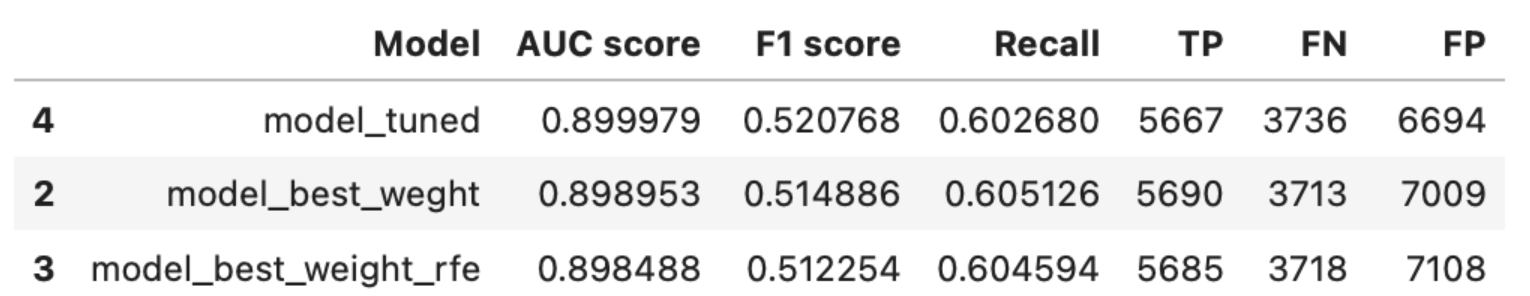

*results before adjusting the thresholds

# Conclusion

# The final decision on the value of the threshold should be guided by specific business objectives and the relative costs associated with false negatives (FN) and false positives (FP).